In [ ]:
import pandas as pd
import numpy as np
from scipy import stats 
from scipy.stats import zscore

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly

import seaborn as sns

import ipywidgets

import json
import os
import sys
import io
import datetime

# Start by mapping 'games' data in original raw format into dataframe
Manually extracting the data from the website has the data in a 1 column list repeating every 4 rows.
1. Date
2. (team a) vs (Team b) - in Home vs Away order
3. (score) to (score)
4. game_id



In [76]:
#df_games = pd.DataFrame(columns = ['GAME_ID', 'DATE', 'SCORE_STR', 'TEAMS_STR'])
df_games = pd.DataFrame(columns = ['GAME_ID', 'DATE', 'SCORE_STR', 'TEAMS_STR', 'TOWN_TEAM_HOME', 'TOWN_TEAM_AWAY', 'GOALS_HOME', 'GOALS_AWAY', 'PTS_HOME', 'PTS_AWAY'])
df_games

#Duplicate 2x - organize by team as the key (independent of home vs away)
df_games_team = pd.DataFrame(columns = ['TOWN_TEAM', 'GAME_ID', 'DATE', 'SEASON', 'IsHome', 'TOWN_TEAM_OPPONENT', 'GOALS_FOR', 'GOALS_AGAINST', 'PTS'])


fp_games = ['../data/Grade 6 Girls Soccer - G6G_FALL2022_SCORES_RAW.csv', 
            '../data/Grade 6 Girls Soccer - G6G_SPRING2022_SCORES_RAW.csv']

for fp in fp_games:
    print(fp)
    file1 = open(fp, 'r')
    lines = file1.readlines()

    count = 0
    # Strips the newline character
    for line in lines:
        count += 1
        lineStr = line.strip()
        #print(lineStr)
        
        if (count % 4) == 1:
            d_dateStr = lineStr
            #print(d_dateStr)
            d_date = datetime.datetime.strptime(d_dateStr, '%m/%d/%Y')
            #d_date = d_dateStr
            
        elif (count % 4) == 2:
            d_teams = lineStr
            teamsArr = d_teams.split('vs.')
            d_team_home = teamsArr[0].strip()
            d_team_away = teamsArr[1].strip()
            
        elif (count % 4) == 3:
            d_scores = lineStr
            #win = 3, tie = 1, loss = 0. Forfeit (-3 forfeiting team, 0 other); double forfeit (both -3).
            if ('forfeit' not in d_scores.lower()):
                goalsArr = d_scores.split('to')
                d_goals_home = int(goalsArr[0])
                d_goals_away = int(goalsArr[1])
                
                if (d_goals_home == d_goals_away):
                    d_pts_home = 1
                    d_pts_away = 1
                elif (d_goals_home > d_goals_away):
                    d_pts_home = 3
                    d_pts_away = 0
                else:
                    d_pts_home = 0
                    d_pts_away = 3
                    
            elif ('away forfeit' in d_scores.lower()):
                d_pts_home = 0
                d_pts_away = -3
            elif ('home forfeit' in d_scores.lower()):
                d_pts_home = -3
                d_pts_away = 0
            elif ('double forfeit' in d_scores.lower()):
                d_pts_home = -3
                d_pts_away = -3
            else:
                print(f'SCORE ERROR({count}): {d_scores}')
            
            
        elif (count % 4) == 0:
            d_gameid = lineStr
            #df_games.append({'GAME_ID' : d_gameid, 'DATE' : d_date, 'SCORE_STR' : d_scores, 'TEAMS_STR' : d_teams}, ignore_index = True) 
            df_games.loc[len(df_games.index)] = [d_gameid, d_date, d_scores, d_teams, d_team_home, d_team_away, d_goals_home, d_goals_away, d_pts_home, d_pts_away]
            
            #['TOWN_TEAM', 'GAME_ID', 'DATE', 'SEASON', 'IsHome', 'TOWN_TEAM_OPPONENT', 'GOALS_FOR', 'GOALS_AGAINST', 'PTS']
            df_games_team.loc[len(df_games_team.index)] = [d_team_home, d_gameid, d_date, 0.0, True, d_team_away, d_goals_home, d_goals_away, d_pts_home]
            df_games_team.loc[len(df_games_team.index)] = [d_team_away, d_gameid, d_date, 0.0, False, d_team_home, d_goals_away, d_goals_home, d_pts_away]
        
    file1.close()

# Convert dataframe columns to desired types
#df_games['DATE']= pd.to_datetime(df_games['DATE'])
df_games['DATE'] = df_games['DATE'].astype('datetime64[ns]')
df_games['GOALS_HOME'] = df_games['GOALS_HOME'].astype('int')
df_games['GOALS_AWAY'] = df_games['GOALS_AWAY'].astype('int')
df_games['PTS_HOME'] = df_games['PTS_HOME'].astype('int')
df_games['PTS_AWAY'] = df_games['PTS_AWAY'].astype('int')




# Map date to determine spring vs fall and create numeric representation for first half spring vs second half fall.
#df_games['YEAR_HALF'] = df_games.apply(lambda x: x.timetuple().tm_yday)
#df_games['YEAR_HALF'] = df['date'].dt.year + df['date'].dt.month.gt(6).add(1).astype(str)
df_games['SEASON'] = np.where(df_games['DATE'].dt.month.le(6), df_games['DATE'].dt.year + 0, df_games['DATE'].dt.year + 0.5)
df_games_team['SEASON'] = np.where(df_games_team['DATE'].dt.month.le(6), df_games_team['DATE'].dt.year + 0, df_games_team['DATE'].dt.year + 0.5)


df_games


../data/Grade 6 Girls Soccer - G6G_FALL2022_SCORES_RAW.csv
../data/Grade 6 Girls Soccer - G6G_SPRING2022_SCORES_RAW.csv


,GAME_ID,DATE,SCORE_STR,TEAMS_STR,TOWN_TEAM_HOME,TOWN_TEAM_AWAY,GOALS_HOME,GOALS_AWAY,PTS_HOME,PTS_AWAY,SEASON
0,G6GM1G1-28469,2022-09-10,2 to 1,Andover Dunn vs. Peabody Lasers,Andover Dunn,Peabody Lasers,2,1,3,0,2022.5
1,G6GM1G1-28459,2022-09-17,0 to 1,Marblehead MILITIA vs. Andover Dunn,Marblehead MILITIA,Andover Dunn,0,1,0,3,2022.5
2,G6GM1G1-28458,2022-09-24,4 to 1,Newburyport Blizzard vs. Andover Dunn,Newburyport Blizzard,Andover Dunn,4,1,3,0,2022.5
3,G6GM1G1-28464,2022-10-01,5 to 3,Andover Dunn vs. Topsfield Masco Vipers,Andover Dunn,Topsfield Masco Vipers,5,3,3,0,2022.5
4,G6GM1G1-28473,2022-10-15,3 to 1,Andover Dunn vs. Newburyport Blizzard,Andover Dunn,Newburyport Blizzard,3,1,3,0,2022.5
...,...,...,...,...,...,...,...,...,...,...,...
1445,S22G6GC2G3-26473,2022-04-30,1 to 4,Triton HURRICANES vs. Andover Rapinoe,Triton HURRICANES,Andover Rapinoe,1,4,0,3,2022.0
1446,S22G6GC2G3-26467,2022-05-07,3 to 5,Andover Rapinoe vs. Beverly Lynx,Andover Rapinoe,Beverly Lynx,3,5,0,3,2022.0
1447,S22G6GC2G3-26483,2022-05-14,1 to 6,Andover Rapinoe vs. Newburyport Storm,Andover Rapinoe,Newburyport Storm,1,6,0,3,2022.0
1448,S22G6GC2G3-26481,2022-05-21,0 to 2,Andover Rapinoe vs. Marblehead ARSENAL,Andover Rapinoe,Marblehead ARSENAL,0,2,0,3,2022.0


In [63]:
# Extract Division from GAME_ID header
#[0]: optional, S=spring, F=fall
#[1]: optional, YY
#[2]: G for Grade
#[3]: grade number
#[4]: G for girls, B for boys
#[5..'-']: Division id
#['-'...]: game number
#str.fullmatch("", case=False)

#df_temp = df_games['GAME_ID'].str.extract(r'(?P<SEASON_IDX>(\w\d\d)?)(?P<GRADE>\w\d)(?P<GENDER>\w)(?P<DIVISION>\w\d\w\d)')
df_temp = df_games['GAME_ID'].str.extract(r'(?P<SEASON_IDX>(\w\d\d)?)G(?P<GRADE>\d)(?P<GENDER>\w)(?P<DIVISION>\w\d\w\d)-(?P<GAME_IDX>\d\d\d\d\d)')
df_temp['GRADE'] = df_temp['GRADE'].astype('int')
df_temp['GAME_IDX'] = df_temp['GAME_IDX'].astype('int')
#df_temp.value_counts()
#print(df_temp.info())
#df_temp.describe()
#print(df_temp['DIVISION'].unique())
df_temp

df_games[['SEASON_IDX','GRADE','GENDER','DIVISION','GAME_IDX']] = df_temp[['SEASON_IDX','GRADE','GENDER','DIVISION','GAME_IDX']]


#print(df_games[['SEASON','SEASON_IDX','GRADE','GENDER','DIVISION']].value_counts())
print(df_games[['SEASON']].value_counts())
print(df_games[['SEASON']].value_counts().sum())
print(df_games.shape)
#print(df_games[['SEASON_IDX']].value_counts())
#print(df_games[['GRADE']].value_counts())
#print(df_games[['GENDER']].value_counts())
#print(df_games[['DIVISION']].value_counts())

df_games
#df_games.info()

SEASON
2022.0    788
2022.5    662
dtype: int64
1450
(1450, 16)


,GAME_ID,DATE,SCORE_STR,TEAMS_STR,TOWN_TEAM_HOME,TOWN_TEAM_AWAY,GOALS_HOME,GOALS_AWAY,PTS_HOME,PTS_AWAY,SEASON,SEASON_IDX,GRADE,GENDER,DIVISION,GAME_IDX
0,G6GM1G1-28469,2022-09-10,2 to 1,Andover Dunn vs. Peabody Lasers,Andover Dunn,Peabody Lasers,2,1,3,0,2022.5,,6,G,M1G1,28469
1,G6GM1G1-28459,2022-09-17,0 to 1,Marblehead MILITIA vs. Andover Dunn,Marblehead MILITIA,Andover Dunn,0,1,0,3,2022.5,,6,G,M1G1,28459
2,G6GM1G1-28458,2022-09-24,4 to 1,Newburyport Blizzard vs. Andover Dunn,Newburyport Blizzard,Andover Dunn,4,1,3,0,2022.5,,6,G,M1G1,28458
3,G6GM1G1-28464,2022-10-01,5 to 3,Andover Dunn vs. Topsfield Masco Vipers,Andover Dunn,Topsfield Masco Vipers,5,3,3,0,2022.5,,6,G,M1G1,28464
4,G6GM1G1-28473,2022-10-15,3 to 1,Andover Dunn vs. Newburyport Blizzard,Andover Dunn,Newburyport Blizzard,3,1,3,0,2022.5,,6,G,M1G1,28473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,S22G6GC2G3-26473,2022-04-30,1 to 4,Triton HURRICANES vs. Andover Rapinoe,Triton HURRICANES,Andover Rapinoe,1,4,0,3,2022.0,S22,6,G,C2G3,26473
1446,S22G6GC2G3-26467,2022-05-07,3 to 5,Andover Rapinoe vs. Beverly Lynx,Andover Rapinoe,Beverly Lynx,3,5,0,3,2022.0,S22,6,G,C2G3,26467
1447,S22G6GC2G3-26483,2022-05-14,1 to 6,Andover Rapinoe vs. Newburyport Storm,Andover Rapinoe,Newburyport Storm,1,6,0,3,2022.0,S22,6,G,C2G3,26483
1448,S22G6GC2G3-26481,2022-05-21,0 to 2,Andover Rapinoe vs. Marblehead ARSENAL,Andover Rapinoe,Marblehead ARSENAL,0,2,0,3,2022.0,S22,6,G,C2G3,26481


In [41]:

# Process string of <town> <team> into columns
uh = df_games['TOWN_TEAM_HOME'].unique()
df_teams = pd.DataFrame({'TOWN_TEAM' : uh})
df_teams = df_teams.sort_values(by='TOWN_TEAM')
#df_teams['TOWN_TEAM'].to_csv('../data/teams_export.csv', index=False)

# Add mapping of town to teams
df_towns = pd.read_csv('../data/towns.csv', header=None, names=['TOWN'])
df_towns = df_towns.sort_values(by='TOWN', key=lambda x: x.str.len(), ascending=False)
df_towns
for town in df_towns['TOWN']:
    i = len(town)
    #print(i, town)
    mask = df_teams['TOWN_TEAM'].str.startswith(town)
    df_teams.loc[mask, 'TOWN'] = town
    df_teams.loc[mask, 'TEAM'] = df_teams.TOWN_TEAM.apply(lambda x: x[i:])

df_teams.to_csv('../data/teams_export.csv', index=False)

df_teams


,TOWN_TEAM,TOWN,TEAM
102,Amesbury Gators,Amesbury,Gators
67,Amesbury STORM,Amesbury,STORM
127,Amesbury Storm,Amesbury,Storm
14,Andover Akers,Andover,Akers
86,Andover Arsenal,Andover,Arsenal
...,...,...,...
114,Winthrop Seasiders,Winthrop,Seasiders
82,Winthrop Waves,Winthrop,Waves
51,Woburn Cobras,Woburn,Cobras
20,Woburn Inferno,Woburn,Inferno


In [71]:
# Split Town and Team from each home and away
pd.merge(left=df_games, right=df_teams, on="")

SyntaxError: unexpected EOF while parsing (1026206935.py, line 2)

# Teams Distribution

TOWN_TEAM    141
TOWN         140
TEAM         140
dtype: int64
                TOWN  TEAM
0            Andover    15
1          Topsfield    10
2               Lynn     9
3    Hamilton-Wenham     9
4      North Andover     8
5         Marblehead     6
6            Danvers     6
7      North Reading     6
8         Georgetown     6
9        Newburyport     5
10         Wakefield     5
11           Ipswich     5
12           Beverly     5
13            Triton     4
14           Methuen     4
15            Dracut     4
16           Peabody     4
17        Swampscott     4
18             Salem     3
19          Winthrop     3
20          Amesbury     3
21         Pentucket     3
22            Woburn     3
23            Saugus     2
24            Revere     2
25  Manchester-Essex     2
26         Haverhill     2
27          Rockport     1
28          Lawrence     1


<AxesSubplot: xlabel='TEAM', ylabel='TOWN'>

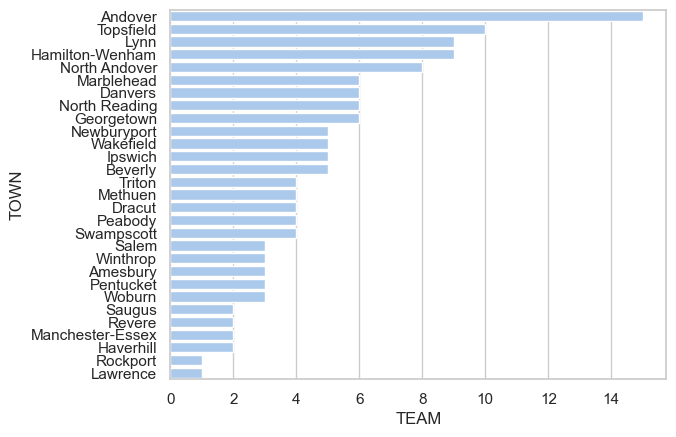

In [61]:
g = df_teams[['TOWN','TEAM']].groupby(by='TOWN').count().sort_values(by='TEAM', ascending=False)
g.reset_index(inplace=True)
print(df_teams.count())
print(g)
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(x="TEAM", y="TOWN", data=g, label="NumTeams", color="b")

# Create standading dataframe per-season

In [69]:
df_standings = pd.DataFrame(columns = ['SEASON', 'DIVISION', 'TEAM', 'TOWN', 'PTS', 'GOALS_FOR', 'GOALS_AGAINST'])
df_standings

ghome = df_games.groupby(by=['SEASON','DIVISION','TOWN_TEAM_HOME'])
ghome
#for name, g1 in ghome:
    #print(name, g1)
    #for name, g2 in g1:
    #    print(name, g2)

# TODO ...

#gaway = g1 = df_games.groupby(by=['SEASON','DIVISION','TOWN_TEAM_AWAY'])

IndentationError: expected an indented block (428507454.py, line 13)

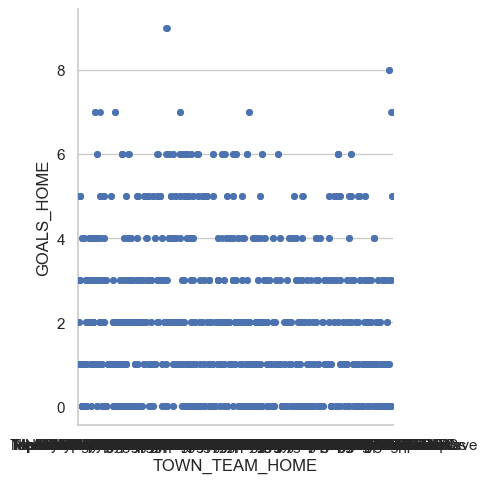

In [70]:
sns.catplot(data=df_games, x="TOWN_TEAM_HOME", y="GOALS_HOME")